## Robustness to reduce steady state error

In broad brushstrokes, the plan is to compute an error signal and pass this through an integrator. This becomes an additional state. So now the state variable, x, goes from 2x1 to 3x1. There is a corresponding increase in size of the other state space matrices. You then choose feedback for this augmented state to make the integral of the error signal fall to zero. Boom. Easy.

In practice, how to do this was not as easy as it could have been. It took a fair amount of searching and head scratching before I got things to work.

I found a page at the University of Michigan website that nudged me in the right direction.
http://ctms.engin.umich.edu/CTMS/index.php?example=MotorPosition&section=ControlStateSpace

This part was not the easiest to understand, so please forgive any mistakes. I am sharing what I learned in the hopes that it may help others. If there are any control engineers reading this, I would welcome your feedback. In particular, when you calculate feedback, should the calculation be done using done continuous time matrices even though it is going to be used in discrete time?!

In [1]:
import matplotlib.pyplot as plt   # MATLAB plotting functions
import control
import control.matlab
import numpy as np

## Augmented matrices

"Augmented" matrices are created that take into account the new state. Let e be the error signal, and r be the reference or desired position. The new state basically defines this relationship.

de/dt = (y - r)

We will call this new variable sigma. So the augmented state will consist of position, velocity, and sigma.

Then select the feedback gain to make this go to zero. Ideally should do this using a linear quadratic regulator (LQR) but I had difficulty getting this to work properly. Perhaps will revisit this after getting the Kalman estimator to work. Stay tuned.


In [2]:
# Parameters defining the system

# Augmented system matrices
Aa = np.matrix( [[0, 1., 0.],
                [0., 0., 0.], 
                [1., 0., 0.]] )
Ba =  np.matrix( [[0.],
                [350.],
                 [0.]] )
Br = np.matrix( [[0.],
                [0.],
                 [-1.]] )

Ca =  np.matrix( [[1., 0., 0.]] )

Tstep = 0.1

## N. B.
It took a while to understand how to implement this. If you try to construct a system with Aa, Ba, and Ca, it will return a system of order 2.  At least that's what the python control library does. Likely because the system as defined is uncontrollable, i.e. third column of Aa and third row of Ba are all zero making the new sigma variable uncontrollable.

The solution? There are two augmented B matrices! Two of them! Ba is used to calculate the gain as well as compute the closed loop augmented A matrix. But in the closed loop system, the Br matrix is used. Who thinks up this stuff?!!

In [17]:
## compute feedback gain

poles = [-2.2, -2., -1.8]
Kfeedback = control.place(Aa, Ba, poles)  ## compute feedback with Ba matrix
print("Kfeedback:")
print(Kfeedback)

Kfeedback:
[[0.03417143 0.01714286 0.02262857]]


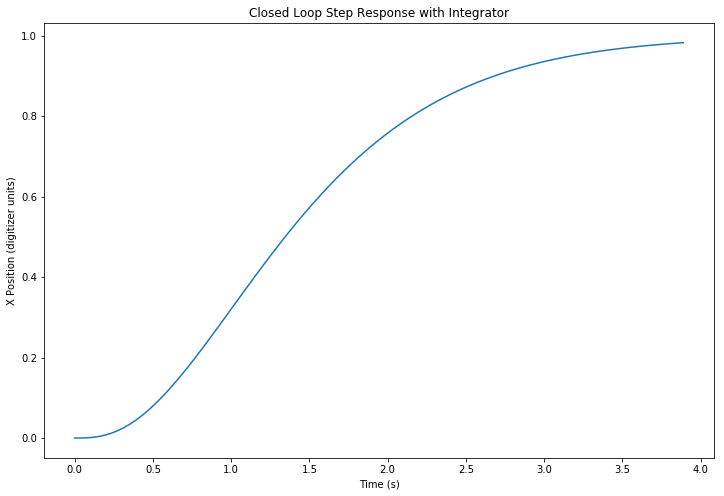

In [18]:
feedbackA = Aa - Ba@Kfeedback  ## augmented closed loop A matrix computed using Ba

sysCLAug = control.ss(feedbackA, Br,Ca, 0)   ## but system is constructed using Br matrix!
T ,yout = control.step_response( sysCLAug)

plt.figure(figsize=(12,8))
plt.plot(T,yout)

plt.xlabel('Time (s)')
plt.ylabel('X Position (digitizer units)')
plt.title('Closed Loop Step Response with Integrator')
plt.show()

## Disturbance response
OK. That's all well and good but it looks mostly the same as before. So what did we gain here? The difference is in its resistance to disturbances.

In [19]:
### system matrices from original system measurement

A = np.matrix( [[0, 1.],
                [0, 0]] )
B =  np.matrix( [[0],
                [350.]] )
C =  np.matrix( [[1., 0]] )

### and make a discrete version so it can be calculated step by step for simulation
syst = control.ss(A,B,C,0)
sysd = control.matlab.c2d(syst, Tstep)

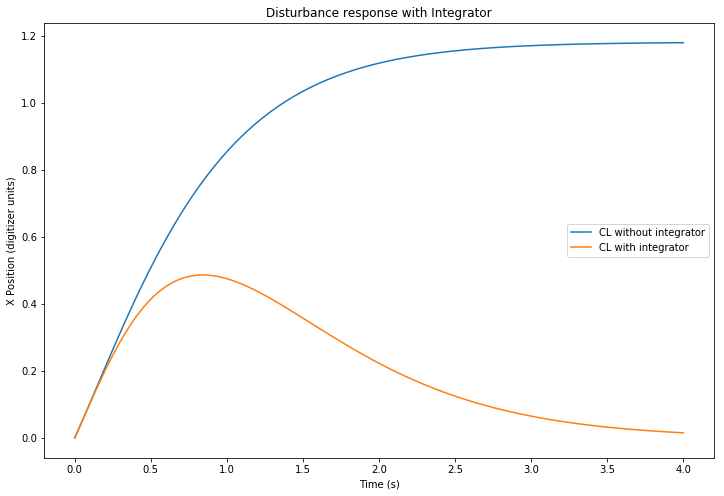

In [20]:
## disturbance response

KfeedbackPrev = np.matrix([[0.01257143 , 0.012 ]])

distSys = control.ss( A - B * KfeedbackPrev,  np.matrix([1,1]). reshape(2,1), C, 0)      ## disturbance sys without error integration
tNoAug, yNoAug = control.step_response(distSys, T=np.linspace(0,4,100))

plt.figure(figsize=(12,8))
plt.plot(tNoAug,yNoAug, label='CL without integrator')

augDistSys = control.ss(feedbackA, np.matrix([1,1,0]).reshape(3,1),Ca, 0) ## augmented dist sys
tAug, yAug = control.step_response(augDistSys,T=np.linspace(0,4,100))

plt.plot(tAug,yAug, label='CL with integrator')
plt.legend(loc="center right")
plt.title('Disturbance response with Integrator')
plt.xlabel('Time (s)')
plt.ylabel('X Position (digitizer units)')
plt.show()

In [21]:
### Make a Luenberger observer. Same as last time.
### find feedback for observer with slightly faster poles than for control feedback.
poles  = [-7, -8]
Kobs = control.place(syst.A.T, syst.C.T, poles).T

sysObs = control.ss(syst.A - Kobs @ syst.C, np.concatenate( (syst.B, Kobs), axis=1), np.eye(2), 0 )

### now make discrete time so we can compute system state recursively
sysObsd = control.matlab.c2d(sysObs,Tstep)

print("Feedback matrix for Luenberger observer:")
print(Kobs)
print("\nSystem matrices for observer:")
print(sysObsd)

Feedback matrix for Luenberger observer:
[[15.]
 [56.]]

System matrices for observer:
A = [[ 0.11853459  0.04725634]
 [-2.64635502  0.82737968]]

B = [[ 1.07887699  0.88146541]
 [32.72287374  2.64635502]]

C = [[1. 0.]
 [0. 1.]]

D = [[0. 0.]
 [0. 0.]]

dt = 0.1



## Manual simulation of integrator
In preparation of translating the integrator to Arduino, do manual computation of augmented system.

Get a "measured" X position. In the simulation, we will "measure" the position from the "real" system. With this measured position and last control input, u, use the observer to compute an estimated state, xhat.

This xhat is then used to update sigma, the new variable that is an integral of the error signal, (estimated position - desired position) * Tstep. Since the real system, i.e. ball and platform, doesn't have a sigma, we will need to calculate and keep track of this manually. It is then concatenated to xhat prior to multiplying by the augmented feedback matrix, Kfeedback, which now is size 1x3.

N.B. The only thing that is augmented here is the new Kfeedback. The observer and "real" system are still both rank 2! (Am I the only one who finds it amusing that the exclamation mark works both grammatically and mathematically?) As such, when doing the feedback calculation, u = -K*x, you need to concatenate sigma to the state variable containing only position and velocity.

In [22]:
obs_U = np.zeros((2,1))       ## Input to the observer system
xhat = np.matrix([[200],[0]])   ## set initial xhat value for observer system

x= np.matrix([[0], [0]])    ## set initial value of x. Mismatched from xhat

xdesired = np.zeros(200)      ## make array of desired positions. Zero to start.
                              ## This will give time for observer to catch up.
xdesired[50:125]= 200         ## then a step up then a step down

xArray = np.matrix([[0], [0], [0]])   ## Arrays of x, xhat, and u to save for plotting
xhatArray = np.matrix([[0], [0]])
uArray = np.matrix([0]).reshape(1,1)
measuredArray = [0]

sigma = 0                      ## our new state variable.
u = np.matrix(0)

for i in range(200):
    measuredX = x[0,0] # measure position of real system. Add noise here

    if i == 100:            ## simulate sensor glitch at 10s
        measuredX = 0.

    measuredArray.append(measuredX)
    obs_U[0,0] = u              ## set up input to observer. Control input
    obs_U[1,0] = measuredX      ## and measured X

    xhat = sysObsd.A @ xhat + sysObsd.B @ obs_U     ### calculate observer estimate

    xhatArray = np.concatenate((xhatArray, xhat), axis = 1)   ### save xhat, u, and x for plotting
    uArray = np.concatenate((uArray, u), axis = 1)
    xArray = np.concatenate((xArray, np.concatenate( (x, np.matrix(sigma)), axis=0)), axis = 1)

    sigma += (xhat[0,0] - xdesired[i])  * Tstep     ### manually update integrator
    
    u =  -Kfeedback @ np.concatenate((xhat, np.matrix(sigma)), axis=0) ## compute u using Kfeedback
                                                                       ## and augmented x state
    x  = sysd.A @ x + sysd.B @ u ## simulate augmented "real" system

t = np.arange(200 + 1)* Tstep

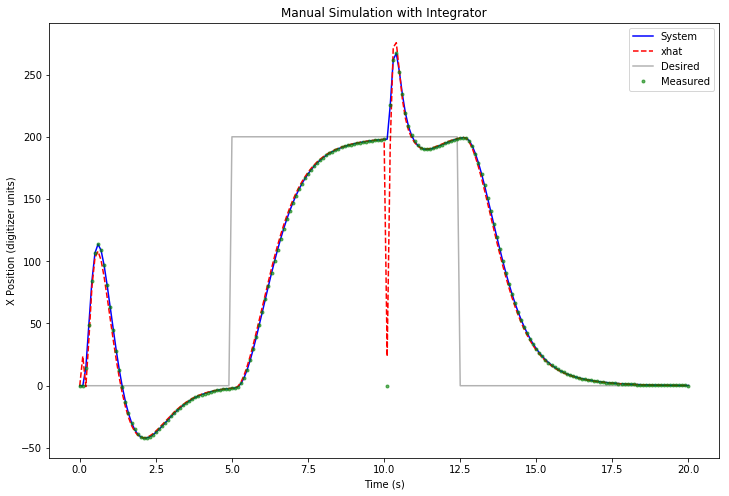

In [23]:
plt.figure(figsize=(12,8))

plt.plot(t,xArray[0,:].T, 'b',label = 'System')
plt.plot(t,xhatArray[0,:].T, 'r--', label = 'xhat')
# plt.plot(t,xArray[2,:].T, 'g',label = 'sigma')
plt.plot(t[0:200], xdesired, 'k-', alpha = 0.3, label='Desired')
plt.plot(t,measuredArray, 'g.', label= 'Measured', alpha =0.6)

plt.xlabel('Time (s)')
plt.ylabel('X Position (digitizer units)')
plt.title('Manual Simulation with Integrator');
plt.legend(loc="top right")
plt.show()

## Sensor Glitch
I simulated a sensor glitch to an x position of 0 at 10s. The observer rapidly approaches to within 60% of the glitch value. The platform is tilted to compensate for the perceived position of the table and the ball is sent in the opposite direction.

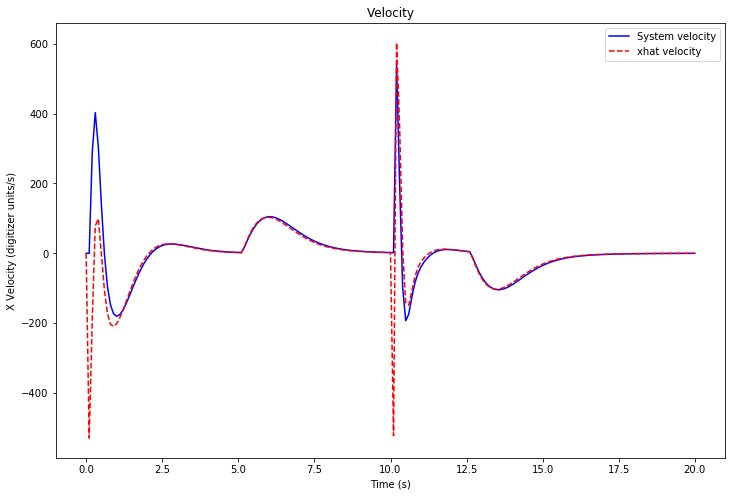

In [24]:
plt.figure(figsize=(12,8))

plt.plot(t,xArray[1,:].T, 'b', label='System velocity' )
plt.plot(t,xhatArray[1,:].T, 'r--', label = 'xhat velocity')

plt.title('Velocity')
plt.xlabel('Time (s)')
plt.ylabel('X Velocity (digitizer units/s)')
plt.legend(loc="upper right")
plt.show()

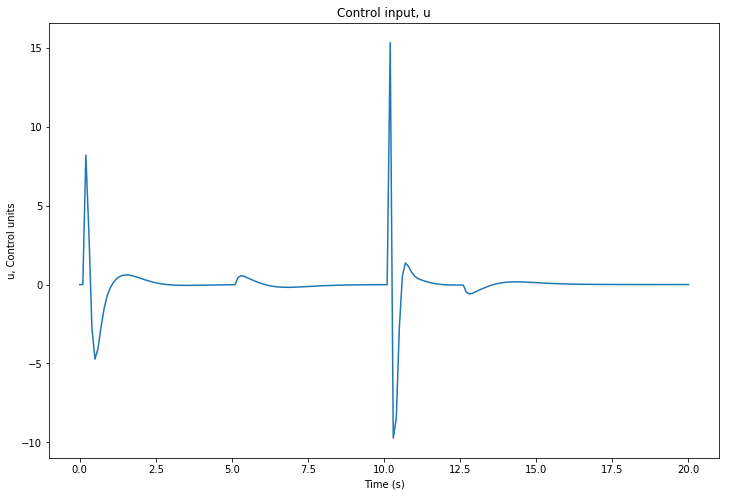

In [25]:
plt.figure(figsize=(12,8))

plt.plot(t,uArray[0:].T)
plt.title('Control input, u')
plt.xlabel('Time (s)') 
plt.ylabel('u, Control units')
plt.show()

OK. This seems to work better. Next up, deglitching the sensor with a Kalman estimator.